In [45]:
# 필요한 라이브러리 호출
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [46]:
# 데이터셋 가져오기
data = pd.read_csv('../data/NVDA.csv')
print(data.dtypes)

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


In [47]:
# 날짜 칼럼을 인덱스로 사용
data['Date'] = pd.to_datetime(data['Date'])
# Date 칼럼을 인덱스로 사용
data.set_index('Date', inplace=True)

In [48]:
# 데이터 형식 변경
# 데이터 타입을 변경할 때는 'astype()' 사용하기
data['Volume'] = data['Volume'].astype(float)

In [50]:
# 훈련과 레이블 처리
X = data.iloc[:, :-1]   # 마지막 컬럼을 제외하는 모든 컬럼을 X로 사용
y = data.iloc[:, 4:5]   # 마지막 'Volume'을 레이블로 사용
print(X)
print(y)

              Open    High     Low   Close
Date                                      
2024-06-13  129.39  129.80  127.16  129.61
2024-06-12  123.06  126.88  122.57  125.20
2024-06-11  121.77  122.87  118.74  120.91
2024-06-10  120.37  123.10  117.01  121.79
2024-06-07  119.77  121.69  118.02  120.89
...            ...     ...     ...     ...
2023-06-20   43.00   43.99   42.67   43.81
2023-06-16   43.45   43.72   42.66   42.69
2023-06-15   42.60   43.29   42.15   42.65
2023-06-14   40.82   43.00   40.55   43.00
2023-06-13   40.19   41.10   39.74   41.02

[253 rows x 4 columns]
                 Volume
Date                   
2024-06-13  255629000.0
2024-06-12  299595000.0
2024-06-11  222551203.0
2024-06-10  314162688.0
2024-06-07  412385776.0
...                 ...
2023-06-20  451153115.0
2023-06-16  655709373.0
2023-06-15  568622024.0
2023-06-14  740464913.0
2023-06-13  613208194.0

[253 rows x 1 columns]


In [51]:
# 데이터 분포 조정
# 데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ms = MinMaxScaler()
# 데이터가 평균 0, 분산 1이 되도록 분산 조정
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Training Shape', X_train.shape, y_train.shape)
print('Testing Shape', X_test.shape, y_test.shape)

Training Shape (200, 4) (200, 1)
Testing Shape (53, 4) (53, 1)


In [52]:
# 데이터셋의 형태 및 크기 조정

# Variable로 감싼 텐서는 .backwward()를 호출할 때, 자동으로 기울기가 계산
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 4]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 4]) torch.Size([53, 1])


In [53]:
# LSTM 네트워크
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        # 클래스 개수
        self.num_classes = num_classes
        # LSTM 계층의 개수
        self.num_layers = num_layers
        # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.input_size = input_size
        # 은닉층의 뉴런 개수
        self.hidden_size = hidden_size
        # 시퀀스 길이
        self.seq_length = seq_length

        # LSTM 계층
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # 완전 연결층
        self.fc_1 = nn.Linear(hidden_size, 128)
        # 출력층
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # 은닉 상태를 0으로 초기화
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # 셀 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        # LSTM 계층에 은닉 상태와 셀 상태 적용
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        # 완전 연결층 적용을 위해 데이터의 형태 조정
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [56]:
# 변수 값 설정

num_epochs, learning_rate = 1000, 0.0001
# 입력 데이터셋의 칼럼 개수, 은닉층의 뉴런/유닛 개수, LSTM 계층의 개수, 클래스 개수
input_size, hidden_size, num_layers, num_classes = 4, 2, 1, 1

model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
# 모델 학습
for epoch in range(num_epochs):
    # 전방향 학습
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    # 손실 함수를 이용한 오차 계산(학습 결과와 레이블의 차이 계산)
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    # 오차 업데이트
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item():1.5f}')

Epoch: 0, loss: 0.06579
Epoch: 100, loss: 0.02025
Epoch: 200, loss: 0.01979
Epoch: 300, loss: 0.01957
Epoch: 400, loss: 0.01935
Epoch: 500, loss: 0.01912
Epoch: 600, loss: 0.01887
Epoch: 700, loss: 0.01864
Epoch: 800, loss: 0.01843
Epoch: 900, loss: 0.01823


In [58]:
# 모델 예측 결과를 출력하기 위한 데이터 크기 재구성
df_x_ss = ss.transform(data.iloc[:, :-1])   # 데이터 정규화(분포 조정)
df_y_ms = ms.transform(data.iloc[:, -1:])   # 데이터 정규화

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))
df_y_ms = Variable(torch.Tensor(df_y_ms))

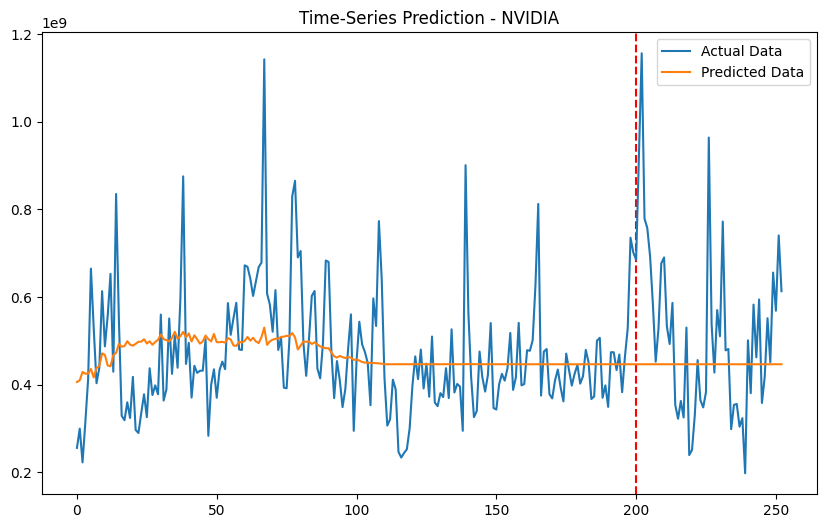

In [62]:
# 모델 예측 결과 출력
train_predict = model(df_x_ss)
# 모델 학습 결과를 넘파이로 변경
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

# 모델 학습을 위해 전처리(정규화)했던 것을 해제, 그래프는 본래의 데이터를 사용할 것이므로
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
# 그래프로 표시
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction - NVIDIA')
plt.legend()
plt.show()